In [52]:
%matplotlib inline

In [53]:
import numpy as np
import os
import networkx as nx
import seaborn as sns


from numpy.linalg import eigh
from scipy import sparse as sp
from scipy.sparse import issparse
from matplotlib import pyplot as plt
from collections import defaultdict

from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs

from helpers import (
    signed_layout, draw_nodes, draw_edges, flatten, get_lcc, signed_laplacian, signed_conductance,
    normalized_laplacian, signed_normalized_laplacian, conductance, dict2array, signed_group_conductance,
    get_borderless_fig
)
from motif_adjacency import motif_eef
from algorithms.pagerank import pr_score

In [73]:
graph_name = 'congress'
path = 'graphs/{}.pkl'.format(graph_name)
fig_rootdir = 'figs/motif_clustering_demo/'

MODE = 'LOCAL'
query = 0
alpha = 0.5  # this should be carefully set
FIG_FORMAT = 'pdf'

fig_dir = os.path.join(fig_rootdir, graph_name)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

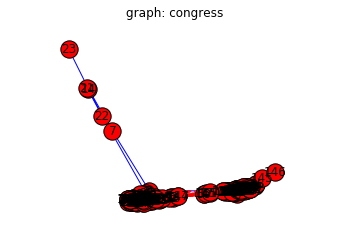

In [74]:
g = nx.read_gpickle(path)

fig, ax = get_borderless_fig()
pos = signed_layout(g)
draw_nodes(g, pos, ax=ax)
# nx.draw_networkx_nodes(g, pos, node_size=100)
draw_edges(g, pos, ax=ax)
ax.set_title('graph: {}'.format(graph_name))
fig.savefig(fig_dir + '/graph.'+FIG_FORMAT)

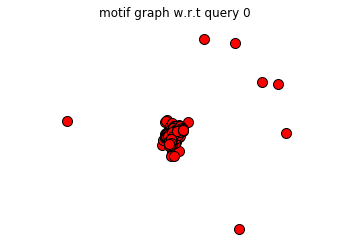

In [75]:
A = nx.adj_matrix(g, weight='sign')
W = motif_eef(A)

g_motif = nx.from_scipy_sparse_matrix(W)

fig, ax = get_borderless_fig()
nx.draw_networkx(g_motif, with_labels=False, node_size=100, ax=ax)
ax.set_title('motif graph w.r.t query {}'.format(query))
fig.savefig(fig_dir + '/motif-graph.' + FIG_FORMAT)

lcc has 212 nodes (g has 219 nodes)
get node score (local) w.r.t node 0
sweeping
best position 211
community [0, 94, 92, 185, 40, 70, 183, 187, 111, 195, 118, 193, 181, 91, 1, 110, 67, 93, 184, 115, 61, 150, 25, 136, 143, 44, 161, 26, 57, 17, 73, 18, 54, 66, 194, 201, 179, 6, 87, 159, 196, 154, 71, 208, 53, 142, 63, 56, 38, 138, 165, 4, 69, 72, 140, 15, 123, 218, 217, 83, 133, 58, 200, 59, 180, 211, 82, 199, 129, 55, 90, 50, 36, 89, 131, 52, 126, 20, 42, 112, 45, 141, 65, 33, 121, 173, 153, 127, 125, 24, 11, 130, 132, 134, 128, 96, 97, 104, 105, 108, 156, 160, 157, 152, 151, 158, 149, 163, 145, 162, 84, 113, 101, 137, 174, 177, 176, 68, 147, 62, 124, 85, 86, 16, 120, 43, 107, 139, 95, 117, 144, 109, 172, 119, 135, 166, 167, 77, 171, 170, 168, 49, 64, 106, 148, 28, 114, 175, 35, 22, 78, 122, 103, 30, 191, 155, 76, 47, 81, 37, 164, 75, 189, 188, 8, 99, 5, 182, 27, 2, 79, 3, 169, 9, 19, 48, 190, 10, 12, 60, 178, 98, 13, 186, 213, 41, 7, 74, 46, 51, 88, 198, 116, 29, 31, 32, 204, 102, 100,

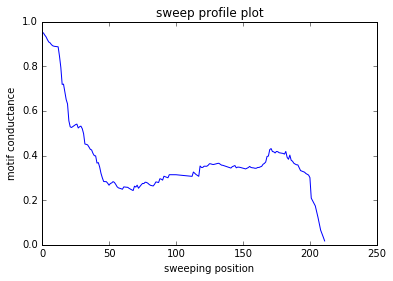

In [76]:
lcc = get_lcc(g_motif)

node_lcc2g = {}
node_g2lcc = {}
for lcc_u, g_u in enumerate(lcc.nodes()):
    node_lcc2g[lcc_u] = g_u
    node_g2lcc[g_u] = lcc_u

query_in_lcc = node_g2lcc.get(query)
if query_in_lcc is None:
    print('query {} is excluded from LCC'.format(query))

lcc = nx.relabel_nodes(lcc, mapping=node_g2lcc, copy=True)

print('lcc has {} nodes (g has {} nodes)'.format(lcc.number_of_nodes(), g.number_of_nodes()))
L_n = normalized_laplacian(nx.adj_matrix(lcc, weight='weight'))

if MODE == 'GLOBAL':    
    print('get node score (global)')
    _, eigvec = eigs(L_n.asfptype(), k=2, which='SM')
    z_vect = eigvec[:, 1]
elif MODE == 'LOCAL':
    print('get node score (local) w.r.t node {}'.format(query))
    z_vect = pr_score(lcc, query_in_lcc, alpha)    
deg = lcc.degree(weight='weight')
deg = dict2array(dict(deg))

node_scores = z_vect / deg

print('sweeping')
order = np.argsort(node_scores)[::-1]
sweep_positions = []
sweep_scores = []
for i in range(1, len(order)):  # omit the last entry
    sweep_positions.append(i)
    s = conductance(lcc, order[:i])
    sweep_scores.append(s)
    
    
fig, ax = plt.subplots(1, 1)
ax.plot(sweep_positions, sweep_scores)
ax.set_title('sweep profile plot')
ax.set_xlabel('sweeping position')
ax.set_ylabel('motif conductance')

# get the best community
best_pos = np.argmin(sweep_scores)
comm = order[:best_pos+1]
print('best position', best_pos+1)

# map back the lcc nodes to g
comm = [node_lcc2g[n] for n in comm]
print('community', comm)
fig.savefig(fig_dir + '/sweep-profile-plot.' + FIG_FORMAT)

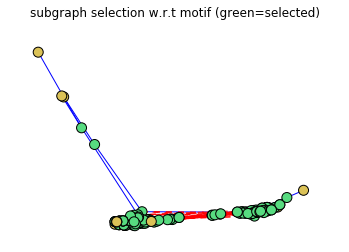

In [77]:
pal = sns.color_palette('hls', 8)
# sns.palplot(pal)

node_color = np.zeros((g.number_of_nodes(), 3))
for i in np.arange(g.number_of_nodes()):
    if i in comm:
        node_color[i] = pal[3]
    else:
        node_color[i] = pal[1]
    
    
fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(g, pos, node_color=node_color, node_size=100, ax=ax)
draw_edges(g, pos, ax=ax)
ax.set_title('subgraph selection w.r.t motif (green=selected)')
fig.savefig(fig_dir + '/subgraph-selection.' + FIG_FORMAT)

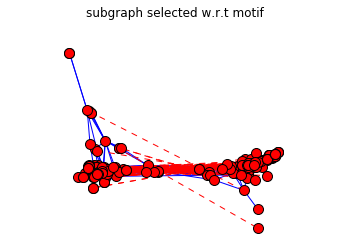

In [78]:
subg = g.subgraph(comm)
subg = nx.convert_node_labels_to_integers(subg)
subg_pos = signed_layout(subg)

# draw_nodes(subg, subg_pos)
fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(subg, subg_pos, node_size=100)
draw_edges(subg, subg_pos)
ax.set_title('subgraph selected w.r.t motif')
fig.savefig(fig_dir + '/subgraph-selected.' + FIG_FORMAT)

In [79]:
L_subg = signed_normalized_laplacian(nx.adj_matrix(subg, weight='sign'))

0.03522504892367906
0.11545988258317025
0.17221135029354206
0.15655577299412915
0.21526418786692758
0.22113502935420742
best k 2


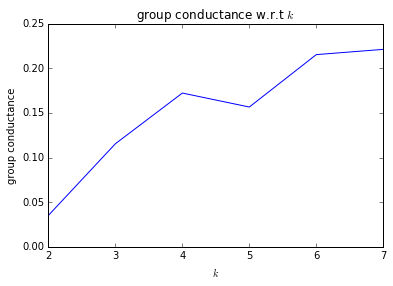

In [80]:
ks = [2, 3, 4, 5, 6, 7]

_, eig_vects = eigs(L_subg.asfptype(), k=max(ks), which='SM')

eig_vects = np.real(eig_vects)

avg_phi_list = []
for k in ks:
    embedding = eig_vects[:, :k]  # top-k eigen vectors
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding)
    labels = kmeans.labels_
    groups = defaultdict(list)    
    for i, l in enumerate(labels):
        groups[l].append(i)
    avg_phi_list.append(signed_group_conductance(subg, groups.values()))
best_k = ks[np.argmin(avg_phi_list)]    
for phi in avg_phi_list:
    print(phi)
print('best k', best_k)

fig, ax = plt.subplots(1, 1)
ax.plot(ks, avg_phi_list)
ax.set_title('group conductance w.r.t $k$')
ax.set_xlabel('$k$')
ax.set_ylabel('group conductance')
fig.savefig(fig_dir + '/group-conductance-sweep.' + FIG_FORMAT)

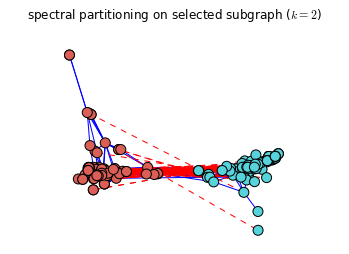

In [81]:
pal = sns.color_palette('hls', best_k)
embedding = eig_vects[:, :best_k]  # top-k eigen vectors
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(embedding)
node_color = np.zeros((subg.number_of_nodes(), 3))
for i in np.arange(subg.number_of_nodes()):
    node_color[i] = pal[kmeans.labels_[i]]

fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(subg, subg_pos, node_size=100, node_color=node_color, ax=ax)
draw_edges(subg, subg_pos, ax=ax)
ax.set_title('spectral partitioning on selected subgraph ($k={}$)'.format(best_k))

fig.savefig(fig_dir + '/partitioning.' + FIG_FORMAT)